In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import json

import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.mstats import gmean
import seaborn as sns; sns.set_style("whitegrid")

from misc import FurnitureDataset, preprocess

In [2]:
train_json = json.load(open('data/train.json'))
train_df_0 = pd.DataFrame(train_json['annotations'])
train_df_1 = pd.DataFrame(train_json['images'])
train_df = pd.merge(train_df_0, train_df_1)

In [3]:
paths = []
val_pred1 = torch.load('inceptionv4_val_prediction.pth', map_location={'cuda:0': 'cpu'})
val_pred2 = torch.load('densenet161_val_prediction.pth', map_location={'cuda:0': 'cpu'})
val_pred3 = torch.load('densenet201_val_prediction.pth', map_location={'cuda:0': 'cpu'})
val_pred4 = torch.load('inceptionresnetv2_val_prediction.pth', map_location={'cuda:0': 'cpu'})
val_pred5 = torch.load('xception_val_prediction.pth', map_location={'cuda:0': 'cpu'})
val_prob = F.softmax(Variable(torch.cat((
    val_pred1['px'],
    val_pred2['px'],
    val_pred3['px'],
    val_pred4['px'],
    val_pred5['px'],
), dim=2)), dim=1).data.numpy()

In [4]:
val_prob = gmean(val_prob, axis=2)
val_pred = np.argmax(val_prob, axis=1)

In [5]:
def calibrate_prob(positive_prob_train, positive_prob_test, prob):
    return (positive_prob_test * prob) / (positive_prob_test * prob + positive_prob_train * (1 - prob))

def calibrate_probs(prob):
    nb_train = train_df.shape[0]
    for class_ in range(128):
        nb_positive_train = ((train_df.label_id - 1) == class_).sum()

        positive_prob_train = nb_positive_train / nb_train
        positive_prob_test = 1 / 128 # balanced class distribution 
        for i in range(prob.shape[0]):
            old_p = prob[i, class_]
            new_p = calibrate_prob(positive_prob_train, positive_prob_test, old_p)
            prob[i, class_] = new_p

In [6]:
calibrate_probs(val_prob)

In [7]:
# Score before calibration
np.mean(val_pred != val_pred1['lx'].numpy())

0.11982364981892615

In [8]:
# Score after calibration
np.mean(np.argmax(val_prob, axis=1) != val_pred1['lx'].numpy())

0.11541489529207999

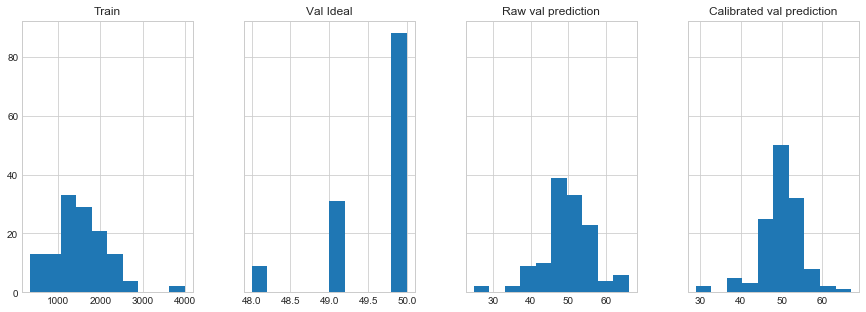

In [9]:
f, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, sharey=True, figsize=(15, 5))
pd.DataFrame(train_df.label_id.value_counts()).hist(ax=ax0)
ax0.set_title('Train')

pd.Series(val_pred1['lx'].numpy()).value_counts().hist(ax=ax1)
ax1.set_title('Val Ideal')

pd.Series(val_pred).value_counts().hist(ax=ax2)
ax2.set_title('Raw val prediction')

pd.DataFrame(np.argmax(val_prob, axis=1))[0].value_counts().hist(ax=ax3)
ax3.set_title('Calibrated val prediction')
f;

# Test prediction

In [10]:
test_pred1 = torch.load('inceptionv4_test_prediction.pth', map_location={'cuda:0': 'cpu'})
test_pred2 = torch.load('densenet161_test_prediction.pth', map_location={'cuda:0': 'cpu'})
test_pred3 = torch.load('densenet201_test_prediction.pth', map_location={'cuda:0': 'cpu'})
test_pred4 = torch.load('inceptionresnetv2_test_prediction.pth', map_location={'cuda:0': 'cpu'})
test_pred5 = torch.load('xception_test_prediction.pth', map_location={'cuda:0': 'cpu'})

In [11]:
test_prob = F.softmax(Variable(torch.cat((
    test_pred1['px'],
    test_pred2['px'],
    test_pred3['px'],
    test_pred4['px'],
    test_pred5['px'],
), dim=2)), dim=1).data.numpy()

In [12]:
test_prob = gmean(test_prob, axis=2)
test_prob.shape

(12688, 128)

In [13]:
test_predicted = np.argmax(test_prob, axis=1) + 1

In [14]:
calibrate_probs(test_prob)
calibrated_predicted = np.argmax(test_prob, axis=1) + 1

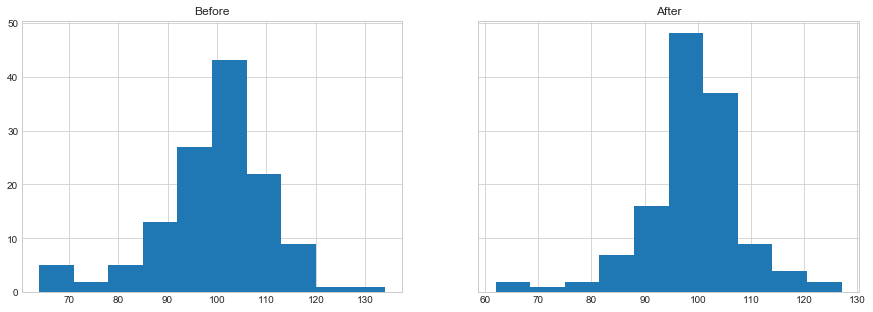

In [15]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
pd.Series(test_predicted).value_counts().hist(ax=ax0)
ax0.set_title('Before')

pd.Series(calibrated_predicted).value_counts().hist(ax=ax1)
ax1.set_title('After')
f;

In [16]:
test_dataset = FurnitureDataset('test', transform=preprocess)
sx = pd.read_csv('data/sample_submission_randomlabel.csv')
sx.loc[sx.id.isin(test_dataset.data.image_id), 'predicted'] = calibrated_predicted
sx.to_csv('sx_calibrated.csv', index=False)

[+] dataset `test` loaded 0 images from 12800
